<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [3]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [24]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

<h3>Get the data and copy it to S3</h3>

In [3]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://mlops-sagemaker-imageclassification/ --recursive

<h3>Set up parameters, estimator, and tuner</h3>

In [8]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [9]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [ ]:
os.environ['SM_CHANNEL_TRAINING']='s3://mlops-sagemaker-imageclassification/'
os.environ['SM_MODEL_DIR']='s3://mlops-sagemaker-imageclassification/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://mlops-sagemaker-imageclassification/output/'
tuner.fit({"training": "s3://mlops-sagemaker-imageclassification/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [15]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-251110-0454')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""256""",0.001063,pytorch-training-251110-0454-001-e2148809,Completed,672.0,2025-11-10 04:56:00+00:00,2025-11-10 05:16:18+00:00,1218.0
0,"""128""",0.035499,pytorch-training-251110-0454-002-e05bd9af,Completed,580.0,2025-11-10 05:19:43+00:00,2025-11-10 05:38:35+00:00,1132.0


## Imp: If kernel dies, how to continue from a completed training job

In [16]:
BetterTrainingJobName='pytorch-training-251110-0454-001-e2148809'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator


2025-11-10 05:19:41 Starting - Starting the training job
2025-11-10 05:19:41 Pending - Preparing the instances for training
2025-11-10 05:19:41 Downloading - Downloading the training image
2025-11-10 05:19:41 Training - Training image download completed. Training in progress.
2025-11-10 05:19:41 Uploading - Uploading generated training model
2025-11-10 05:19:41 Completed - Resource reused by training job: pytorch-training-251110-0454-002-e05bd9af


<h3>Prepare to perform Training on Best Estimator</h3>

In [17]:
best_estimator=tuner.best_estimator()



2025-11-10 05:38:37 Starting - Found matching resource for reuse
2025-11-10 05:38:37 Downloading - Downloading the training image
2025-11-10 05:38:37 Training - Training image download completed. Training in progress.
2025-11-10 05:38:37 Uploading - Uploading generated training model
2025-11-10 05:38:37 Completed - Resource retained for reuse


In [18]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"128"',
 'learning_rate': '0.035498763735876016',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2025-11-10-04-54-25-297"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-915346260059/pytorch_dog_hpo-2025-11-10-04-54-25-297/source/sourcedir.tar.gz"'}

In [19]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 128, 'learning_rate': '0.035498763735876016'}

In [20]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [21]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<h2>Creating an Estimator</h2>

In [25]:
# Single instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [23]:
estimator.fit({"training": "s3://mlops-sagemaker-imageclassification/"}, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2025-11-10-05-42-16-121


<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [27]:
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=3,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [28]:
estimator.fit({"training": "s3://mlops-sagemaker-imageclassification/"}, wait=False)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2025-11-10-05-46-23-254


<h2>Deployment</h2>

In [29]:
model_location=estimator.model_data


In [33]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [34]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [35]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [36]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-915346260059/dog-pytorch-2025-11-10-05-46-23-254/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-915346260059/pytorch-inference-2025-11-10-06-10-03-275/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2025-11-10-06-10-13-244
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2025-11-10-06-10-13-873
INFO:sagemaker:Creating endpoint with name pytorch-inference-2025-11-10-06-10-13-873


------!

In [37]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

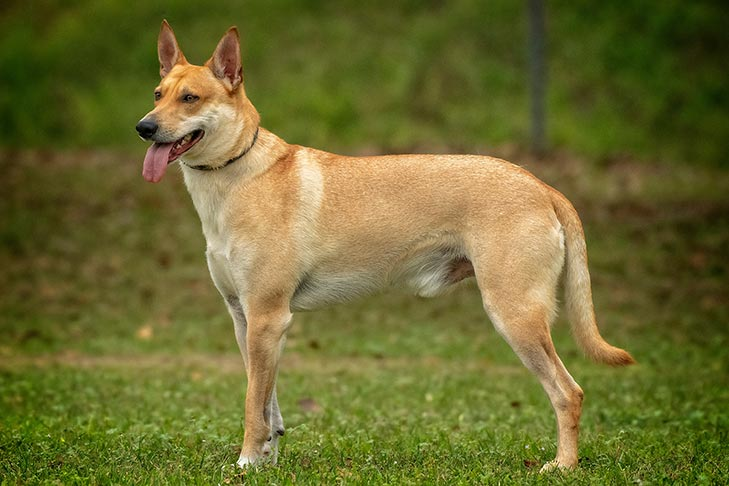

In [38]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [41]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [39]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [43]:
type(response2[0][0])

float

In [40]:
response2[0]

[0.31003132462501526,
 0.34280091524124146,
 0.21377412974834442,
 0.4591186046600342,
 0.5280706882476807,
 0.4166642129421234,
 0.2271832972764969,
 0.5134561657905579,
 -0.10201482474803925,
 0.20892022550106049,
 0.4395408630371094,
 0.43519240617752075,
 0.181331068277359,
 0.5582130551338196,
 0.6346795558929443,
 0.31924617290496826,
 0.2505859434604645,
 0.22714142501354218,
 0.16090106964111328,
 0.42494916915893555,
 0.2078286111354828,
 0.11043079942464828,
 0.38689282536506653,
 0.3908540606498718,
 -0.09737931936979294,
 0.09817540645599365,
 0.37407973408699036,
 -0.12616613507270813,
 0.04297060891985893,
 0.3091364800930023,
 0.3153112232685089,
 0.3842286169528961,
 0.10543844103813171,
 0.4436326324939728,
 0.33734333515167236,
 -0.1505177617073059,
 0.2010706067085266,
 0.43080127239227295,
 0.42726102471351624,
 0.29566681385040283,
 0.2540779113769531,
 0.2817000150680542,
 0.268750935792923,
 0.42973706126213074,
 0.32518985867500305,
 0.2508881390094757,
 0.17434

In [44]:
import torch
import numpy as np
np.argmax(response2, 1)

array([14])